In [20]:
import numpy as np

import hdbscan

import logging

import matplotlib.pyplot as plt

In [2]:
%cd ..
%load_ext autoreload

c:\Users\kepes\Projects\segmentation


In [3]:
%autoreload 2
from src.MapData import MapData

In [4]:
map_data = MapData()
map_data.get_metadata()
map_data.get_map_dimensions()
map_data.load_wavelenths()

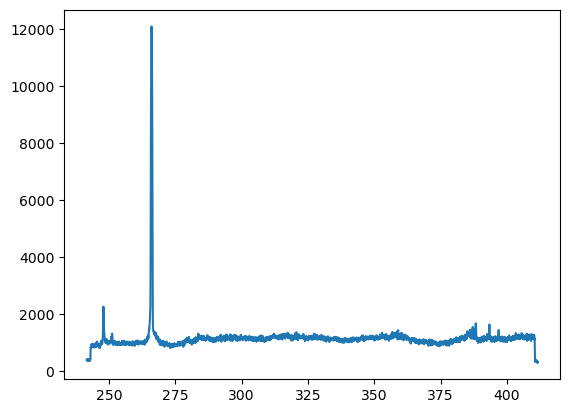

In [9]:
map_data.plot_random_spectrum()

In [10]:
map_data.load_all_data()

In [12]:
full_emissivities = map_data.spectra.sum(axis=1)

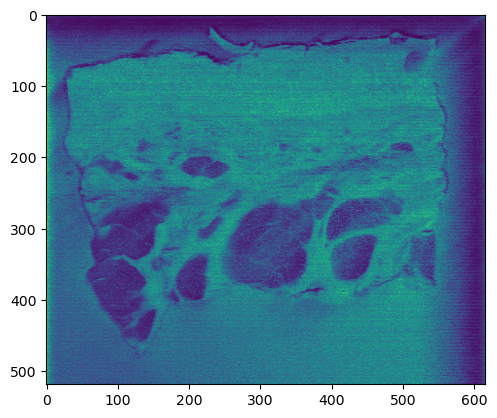

In [18]:
full_emissivities = full_emissivities.reshape(map_data.map_dimensions[::-1])
full_emissivities[::2,:] = full_emissivities[::2,::-1]

plt.imshow(full_emissivities)

In [125]:
from sklearn.metrics.pairwise import cosine_distances
from sklearn.decomposition import PCA

In [131]:
PC_COUNT = 18

pca_model = PCA(n_components=PC_COUNT)

In [147]:
STEP_SIZE = 20

dist_matrix = cosine_distances(map_data.spectra[::STEP_SIZE,:])
dist_matrix = dist_matrix.astype(np.float64)

pca_scores = pca_model.fit_transform(map_data.spectra[::STEP_SIZE,:])

In [159]:
def plot_pca_scores(
    scores,
    explained_variances=None,
    colors=None
):
    explained_variances *= 100
    pc_count = scores.shape[1]

    if colors is None: colors = [1] * len(scores)

    col_count = np.max([
        3,
        int(np.sqrt(pc_count // 2))
    ])
    row_count = np.max([
        3, 
        int(np.sqrt(pc_count // 2))
    ])

    fig, ax = plt.subplots(
        ncols=col_count,
        nrows=row_count
    )

    for pc_ndx in range(col_count * row_count):    
        ax[pc_ndx // col_count,pc_ndx % row_count].scatter(
            x=scores[:,pc_ndx*2],
            y=scores[:,pc_ndx*2+1],
            s=.5,
            alpha=.2,
            c=colors
        )
        ax[pc_ndx // col_count,pc_ndx % row_count].set_xlabel(
            f'PC{pc_ndx*2 + 1} ({explained_variances[pc_ndx*2]:.2f} %)'
        )
        ax[pc_ndx // col_count,pc_ndx % row_count].set_ylabel(
            f'PC{pc_ndx*2 + 2} ({explained_variances[pc_ndx*2 + 1]:.2f} %)'
        )    
        ax[pc_ndx // col_count,pc_ndx % row_count].set_xticks([])
        ax[pc_ndx // col_count,pc_ndx % row_count].set_yticks([])

    fig.tight_layout()
    fig.show()

C:\Users\kepes\AppData\Local\Temp\ipykernel_21088\2518037681.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


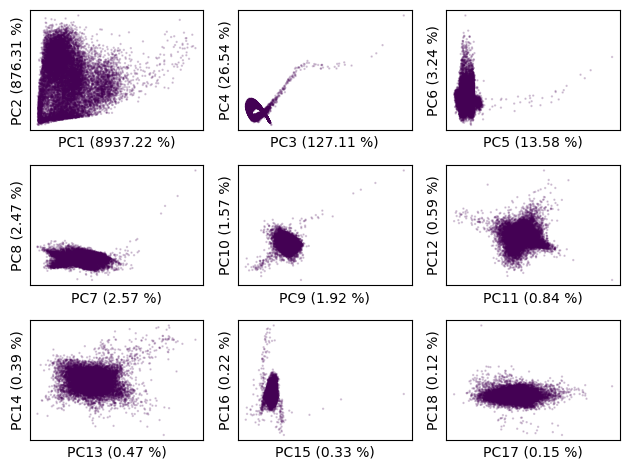

In [160]:
plot_pca_scores(
    pca_scores,
    pca_model.explained_variance_ratio_
)

In [119]:
clusterer = hdbscan.HDBSCAN(
    algorithm='best', 
    alpha=.01,
    approx_min_span_tree=True,
    gen_min_span_tree=False, 
    leaf_size=20,
    metric='precomputed',
    min_cluster_size=50,
    min_samples=30,
    p=None,
    core_dist_n_jobs=3
)

clusterer.fit(dist_matrix)

HDBSCAN(alpha=0.01, core_dist_n_jobs=3, leaf_size=20, metric='precomputed',
        min_cluster_size=50, min_samples=30)

In [120]:
plot_labels = clusterer.labels_.copy()

counts, bins = np.histogram(
    plot_labels,
    bins=np.arange(-1,len(
        np.unique(plot_labels)
    ))
)

main_cluster_id = bins[np.argmax(counts)]

print(
    f'the most populous cluster is {main_cluster_id}'
)

main_cluster_cond = clusterer.labels_ == main_cluster_id

the most populous cluster is 2


C:\Users\kepes\AppData\Local\Temp\ipykernel_21088\2518037681.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


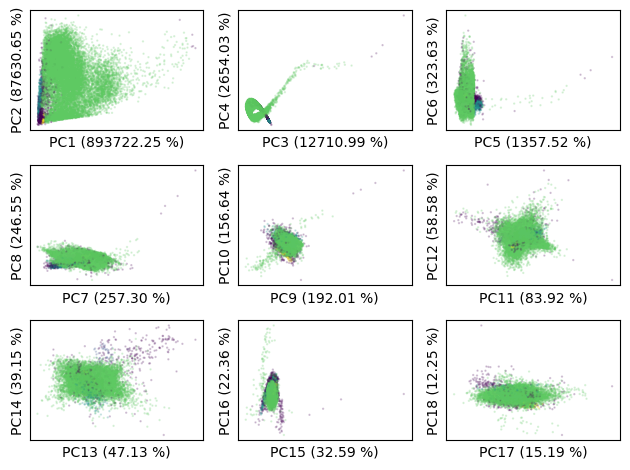

In [163]:
plot_pca_scores(
    pca_scores,
    explained_variances=pca_model.explained_variance_ratio_,
    colors=plot_labels
)

In [123]:
plot_data = np.zeros_like(
    np.arange(map_data.metadata.get('spectra'))
).astype(np.float32)
plot_data += .2
plot_data[::STEP_SIZE] = plot_labels
plot_data = np.ma.array(plot_data, mask=np.isnan(plot_data))

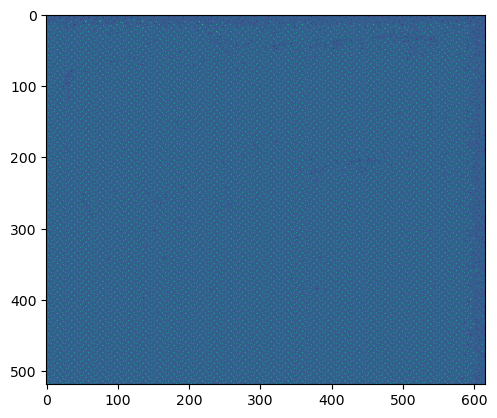

In [124]:
plot_data = plot_data.reshape(map_data.map_dimensions[::-1])
plot_data[::2,:] = plot_data[::2,::-1]

plt.imshow(plot_data)

In [112]:
plot_data

masked_array(
  data=[[0.0, 0.0, 0.0, ..., 0.0, 0.0, -1.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        ...,
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0]],
  mask=[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],
  fill_value=1e+20,
  dtype=float32)